In [1]:
# Import the dependencies

import os
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Define directory containing the csv files
dir_path = Path("../Resources")

# create an empty list to hold the dataframes 
dfs = []

# loop through each file in the directory
for file in os.listdir(dir_path):
    # check if the file is a csv file
    if file.endswith(".csv"):
        # extract the ticker symbol from the file name (assuming the file name is the ticker symbol)
        ticker = file.replace(".csv", "")
        # Read the file into a DataFrame
        stocks_df = pd.read_csv(dir_path / file)
        # Add a column to the DataFrame to store the ticker symbol
        stocks_df["Ticker"] = ticker
        # add the dataframe to the list
        dfs.append(stocks_df)
        
# concatenate the dataframes in the list
combined_stocks_df = pd.concat(dfs, ignore_index=True)

# Display the combined DataFrame to verify
print(combined_stocks_df.head())

# change the type in 'date' column to datetime
combined_stocks_df["Date"] = pd.to_datetime(combined_stocks_df["Date"])

# Filter the data for the last 10 years from today
ten_years_ago = pd.Timestamp.today() - pd.DateOffset(years=10)
stocks_data_filtered = combined_stocks_df[combined_stocks_df["Date"] >= ten_years_ago]

print(stocks_data_filtered.head())
print(stocks_data_filtered.tail())

# List of specific stocks to analyze
stocks_to_analyze = ['BKNG', 'KHC', 'PEP', 'TCOM']

# Initialize dictionaries to hold the MSE and predictions for each stock symbol
mse_dict = {}
predictions_dict = {}

# Iterate through each stock in the list of specific stocks
for stock in stocks_to_analyze:
    # Select the stock's data
    stock_data = stocks_data_filtered[stocks_data_filtered["Ticker"] == stock]
    
    # Display the selected stock data
    print(f"Selected stock data for {stock}:")
    print(stock_data.head())
    
    # Set the date as the index
    stock_data.set_index("Date", inplace=True)
    
    # Define a feature in the data for previous date closing prices
    stock_data["Previous Day Close"] = stock_data["Close"].shift(1)
    
    # Define a feature in the data for the volume
    stock_data["Volume Difference"] = stock_data["Volume"].diff()
    
    # Drop rows with NaN values
    stock_data = stock_data.dropna()
    
    # Define the features (X) and the target (y) variables for training purposes
    X = stock_data[["Previous Day Close", "Volume Difference"]]
    y = stock_data["Close"].values.reshape(-1, 1) 
    
    # Split the data into training and testing sets chronologically
    split = int(0.7 * len(X))
    X_train = X[: split]
    X_test = X[split:]
    y_train = y[: split]
    y_test = y[split:]
    
    # Normalize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define the neural network model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model with epochs
    model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)
    
    # Make predictions using the testing data
    predictions = model.predict(X_test_scaled)
    
    # Calculate the mean_squared_error on the testing data
    mse = mean_squared_error(y_test, predictions)
    print(f"MSE for {stock}: {mse}")
    
    # Store the MSE in the dictionary
    mse_dict[stock] = mse
    
    # Make a prediction for the values of the stock over the next year starting from the last date in the dataset
    # Create a dataframe to hold the predictions
    future_dates = pd.date_range(start=stock_data.index[-1], periods=60, freq='M')
    future_dates_df = pd.DataFrame(future_dates, columns=["Date"])
    future_dates_df.set_index("Date", inplace=True)
    
    # Initialize previous_close with the last available close value
    previous_close = stock_data["Close"].iloc[-1]
    volume_difference = 0

    # Predict the future values iteratively
    future_closes = []
    for date in future_dates_df.index:
        # prepare the input data for prediction
        input_data = pd.DataFrame({"Previous Day Close": [previous_close], "Volume Difference": [volume_difference]})
        input_data_scaled = scaler.transform(input_data)
        # Make the prediction
        predicted_close = model.predict(input_data_scaled)[0][0]
        # Append the predicted close to the list
        future_closes.append(predicted_close)
        # Update previous_close for the next iteration
        previous_close = predicted_close
    
    # Add the predictions to the dataframe
    future_dates_df["Close"] = future_closes
    
    # Store the predictions in the dictionary
    predictions_dict[stock] = future_dates_df

# Display the predictions for each stock ticker
for stock, future_dates_df in predictions_dict.items():
    print(f"Predictions for {stock}:")
    print(future_dates_df)

# Define the base path as the parent directory of "Notebooks" and "Resources"
base_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Create a directory named "Predictions" within the base path if it doesn't exist
predictions_folder = os.path.join(base_path, "Food and Travel Five Year Predictions")
if not os.path.exists(predictions_folder):
    os.makedirs(predictions_folder)

# Save the Predictions results to individual files in the "Predictions" folder
for stock, future_dates_df in predictions_dict.items():
    prediction_file_path = os.path.join(predictions_folder, f"predictions_{stock}.csv")
    future_dates_df.to_csv(prediction_file_path)

print(f"Prediction results saved to the folder: {predictions_folder}")

# Create a directory named "MSE" within the base path if it doesn't exist
mse_folder = os.path.join(base_path, "Food and Travel Five Year MSE Output")
if not os.path.exists(mse_folder):
    os.makedirs(mse_folder)

# Define the path to save the MSE results file
mse_file_path = os.path.join(mse_folder, "mse_results.csv")

# Save the MSE results to a file in the "MSE" folder
mse_df = pd.DataFrame(list(mse_dict.items()), columns=["Stock Ticker", "Mean Squared Error"])
mse_df.to_csv(mse_file_path, index=False)

print(f"MSE results saved to: {mse_file_path}")


2024-06-09 08:01:18.203282: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_6680/2766335977.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_stocks_df = pd.concat(dfs, ignore_index=True)


         Date  Open      High       Low     Close  Adj Close     Volume Ticker
0  1990-02-16   0.0  0.079861  0.073785  0.077257   0.052392  940636800   CSCO
1  1990-02-20   0.0  0.079861  0.074653  0.079861   0.054158  151862400   CSCO
2  1990-02-21   0.0  0.078993  0.075521  0.078125   0.052980   70531200   CSCO
3  1990-02-22   0.0  0.081597  0.078993  0.078993   0.053569   45216000   CSCO
4  1990-02-23   0.0  0.079861  0.078125  0.078559   0.053275   44697600   CSCO
           Date       Open       High        Low      Close  Adj Close  \
6125 2014-06-10  24.730000  25.100000  24.600000  25.000000  18.296734   
6126 2014-06-11  24.850000  25.170000  24.790001  25.040001  18.326017   
6127 2014-06-12  24.950001  25.010000  24.620001  24.660000  18.047903   
6128 2014-06-13  24.670000  24.780001  24.600000  24.700001  18.077181   
6129 2014-06-16  24.520000  24.730000  24.450001  24.530001  17.952761   

        Volume Ticker  
6125  36582000   CSCO  
6126  36170300   CSCO  
6127  269

/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_6680/2766335977.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["Previous Day Close"] = stock_data["Close"].shift(1)
/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_6680/2766335977.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["Volume Difference"] = stock_data["Volume"].diff()
/Users/paulettepetracco/Bootcamp_Code_Challenges/GH_Repositories/Project_4/.venv/lib/python3.10/site-packages/keras/src/layers/cor

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2686929.2500 - val_loss: 3633668.7500
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2645545.7500 - val_loss: 3618300.2500
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2594435.5000 - val_loss: 3578920.5000
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2577597.2500 - val_loss: 3501031.7500
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2520429.5000 - val_loss: 3369445.2500
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2411851.0000 - val_loss: 3173102.2500
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2289242.0000 - val_loss: 2908351.7500
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2044157.1250 - val_loss: 2579055.7500
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1775558.7500 - val_loss: 2203823.7500
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1539328.3750 - val_loss: 1786627.8750
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 

/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_6680/2766335977.py:117: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=stock_data.index[-1], periods=60, freq='M')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_6680/2766335977.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["Previous Day Close"] = stock_data["Close"].shift(1)
/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_6680/2766335977.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["Volume Difference"] = stock_data["Volume"].diff()
/Users/paulettepetracco/Bootcamp_Code_Challenges/GH_Repositories/Project_4/.venv/lib/python3.10/site-packages/keras/src/layers/cor

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4388.9424 - val_loss: 1259.1288
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4313.7173 - val_loss: 1111.9550
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3841.1418 - val_loss: 819.7223
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2665.0427 - val_loss: 468.2667
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1516.6450 - val_loss: 219.4373
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 475.1597 - val_loss: 111.9600
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 191.5084 - val_loss: 85.4485
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 164.7955 - val_loss: 78.9829
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 94.3376 - val_loss: 71.1356
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 89.1542 - val_loss: 67.2914
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 130.7348 - val_loss: 59.0831
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s

/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_6680/2766335977.py:117: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=stock_data.index[-1], periods=60, freq='M')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_6680/2766335977.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["Previous Day Close"] = stock_data["Close"].shift(1)
/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_6680/2766335977.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["Volume Difference"] = stock_data["Volume"].diff()
/Users/paulettepetracco/Bootcamp_Code_Challenges/GH_Repositories/Project_4/.venv/lib/python3.10/site-packages/keras/src/layers/cor

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 11631.5225 - val_loss: 17929.5840
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11166.4062 - val_loss: 16033.2012
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9442.6318 - val_loss: 12654.7686
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6219.7500 - val_loss: 8299.3721
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3084.8186 - val_loss: 4342.7827
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1465.2388 - val_loss: 1766.9790
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 894.5687 - val_loss: 702.5933
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 656.7476 - val_loss: 522.9058
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 318.3197 - val_loss: 529.0594
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 408.2498 - val_loss: 504.5947
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 196.3772 - val_loss: 459.0563
Epoch 12/50
44/44 ━━━━━━

/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_6680/2766335977.py:117: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=stock_data.index[-1], periods=60, freq='M')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_6680/2766335977.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["Previous Day Close"] = stock_data["Close"].shift(1)
/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_6680/2766335977.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["Volume Difference"] = stock_data["Volume"].diff()
/Users/paulettepetracco/Bootcamp_Code_Challenges/GH_Repositories/Project_4/.venv/lib/python3.10/site-packages/keras/src/layers/cor

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1594.5757 - val_loss: 901.8230
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1426.3129 - val_loss: 639.2917
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1033.5752 - val_loss: 279.8396
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 475.5915 - val_loss: 105.3197
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 142.1943 - val_loss: 59.9254
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82.2539 - val_loss: 42.0934
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49.7503 - val_loss: 32.0358
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35.2748 - val_loss: 24.4443
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.2686 - val_loss: 18.7753
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.4018 - val_loss: 14.4451
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.3473 - val_loss: 11.0113
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_6680/2766335977.py:117: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=stock_data.index[-1], periods=60, freq='M')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

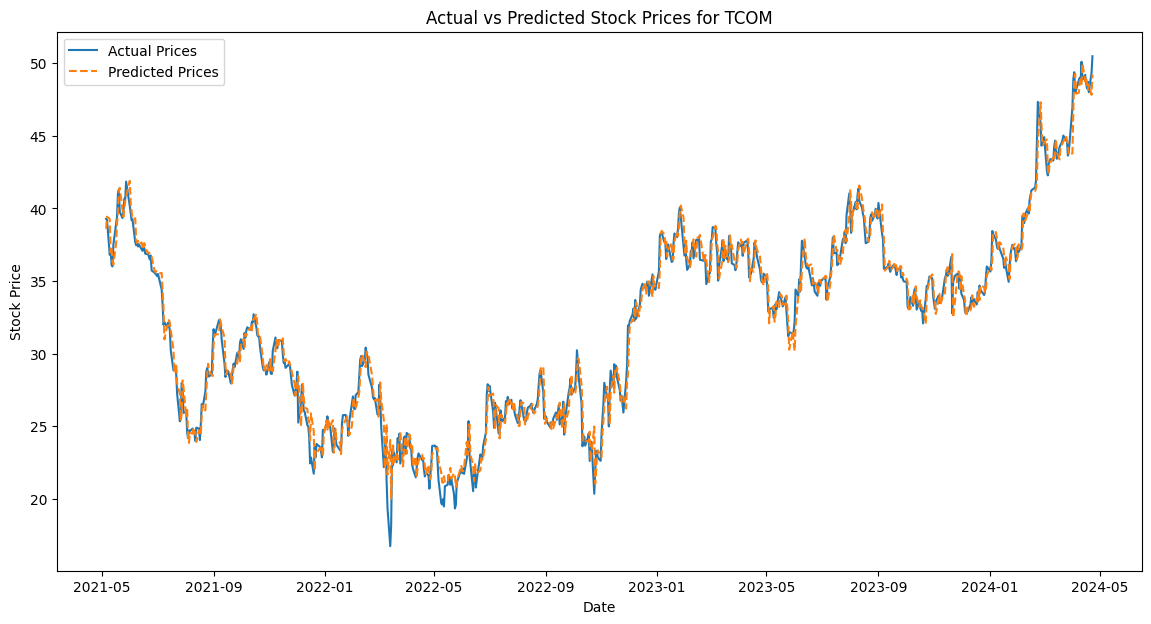

In [2]:
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index[split:], y_test, label='Actual Prices')
plt.plot(stock_data.index[split:], predictions, label='Predicted Prices', linestyle='--')
plt.title(f"Actual vs Predicted Stock Prices for {stock}")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


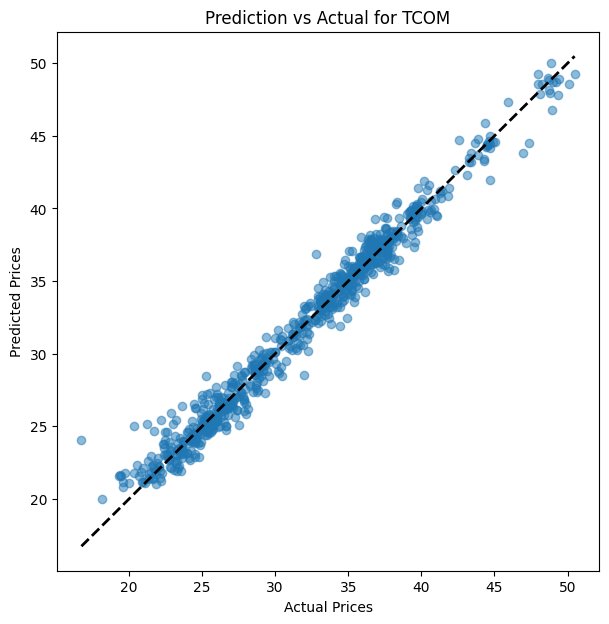

In [3]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title(f"Prediction vs Actual for {stock}")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.show()


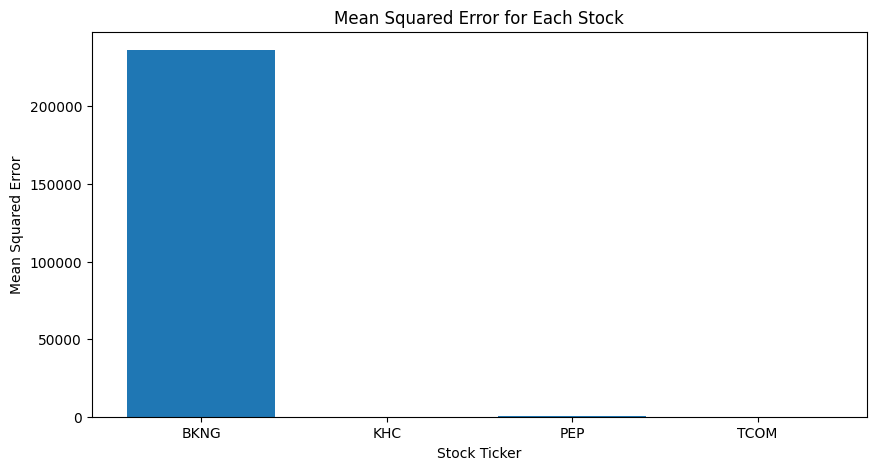

In [6]:
mse_df = pd.DataFrame(list(mse_dict.items()), columns=["Stock Ticker", "Mean Squared Error"])
plt.figure(figsize=(10, 5))
plt.bar(mse_df["Stock Ticker"], mse_df["Mean Squared Error"])
plt.title("Mean Squared Error for Each Stock")
plt.xlabel("Stock Ticker")
plt.ylabel("Mean Squared Error")
plt.show()